In [64]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Importação da base de dados

In [2]:
conexao = mysql.connector.connect(
    host="localhost", 
    user="root",   
    password="FCeara@2025",
    database="doadores_ml" 
)

cursor = conexao.cursor()

paciente = pd.read_sql("SELECT * FROM paciente", conexao)
exame = pd.read_sql("SELECT * FROM exame", conexao)

cursor.close()
conexao.close()

C:\Users\clebe\AppData\Local\Temp\ipykernel_8808\2304271698.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  paciente = pd.read_sql("SELECT * FROM paciente", conexao)
C:\Users\clebe\AppData\Local\Temp\ipykernel_8808\2304271698.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  exame = pd.read_sql("SELECT * FROM exame", conexao)


### Geração da tabela ABT

In [3]:
ABT = pd.merge(exame, paciente, how="inner", on="paciente_id")
ABT = ABT[ABT['tipo_ensaio'] == "Anti-S"]

In [4]:
## Tratamentos
#### Apenas 3 classes de escolaridade
ABT = ABT.replace({'POS GRADUADO': 'TERCEIRO GRAU COMPLETO',
                   'ESPECIALIZADO': 'TERCEIRO GRAU COMPLETO',
                   'MESTRADO': 'TERCEIRO GRAU COMPLETO',
                   'DOUTORADO': 'TERCEIRO GRAU COMPLETO',
                   'TERCEIRO GRAU INCOMPLETO': 'ENSINO MEDIO COMPLETO',
                   'FUNDAMENTAL I': 'ENSINO MEDIO INCOMPLETO',
                   'FUNDAMENTAL II': 'ENSINO MEDIO INCOMPLETO',
                   'NAO ALFABETIZADO': 'ENSINO MEDIO INCOMPLETO'})

#### Diminuir o tamanho de "Pfizer"
ABT = ABT.replace({'PFIZER (12 ANOS OU MAIS)': 'PFIZER'})

#### Remover "Não informado"
ABT = ABT.replace({'NAO INFORMADO': ''})

#### Criação da classe "Target"
ABT['grupos'] = np.where(ABT['quantitativo_igg'] >= 5000, 1, 0)


### Variáveis independentes (features) e dependente (target)

In [5]:
features = ['num_doses', 'genero', 'escolaridade', 'etnia', 
            'fabricante_dose01', 'fabricante_dose02',
            'fabricante_dose03', 'fabricante_dose04']

X = ABT[features]

y = ABT['grupos']

### OneHotEncoding

In [11]:
X = pd.get_dummies(X, columns=['genero', 'escolaridade', 'etnia', 
                               'fabricante_dose01', 'fabricante_dose02',
                               'fabricante_dose03', 'fabricante_dose04'])

### Normalização das classes

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler() 

X_normalized = scaler.fit_transform(X)

# Machine Learning

In [15]:
from sklearn.model_selection import train_test_split

#### Separação entre grupo de treino, validação e teste

In [16]:
#Treino (train) = 60%
#Validação (eval) = 20%
#Teste (test) = 20% 
X_train_eval, X_test, y_train_eval, y_test = train_test_split(
    X, y, random_state=0, test_size=0.20)

X_train, X_eval, y_train, y_eval = train_test_split(
    X_train_eval, y_train_eval, random_state=0, test_size=0.25)

# X_train
# X_eval
# X_test

# y_train
# y_eval
# y_test

#### Checagens

In [ ]:
# Variável resposta é um evento raro?
print("Média-treino:", y_train.mean())
print("Média-validação:", y_eval.mean())
print("Média-teste:", y_test.mean())

Média-treino: 0.443961502638932
Média-validação: 0.4506517690875233
Média-teste: 0.43947858472998136


In [29]:
# Há dados faltantes?
print("Faltantes-treino: ", X_train.isna().sum().sum())
print("Faltantes-validação: ", X_eval.isna().sum().sum())
print("Faltantes-teste: ", X_test.isna().sum().sum())

Faltantes-treino:  0
Faltantes-validação:  0
Faltantes-teste:  0


### Modelos...

In [46]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

Escolha dos melhores hiperparâmetros (Grid Search)

In [47]:
### Árvore de decisão
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

#--------------------
#Randon Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(),
    param_grid_rf,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

#--------------------
#Regressão Logística
param_grid_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'max_iter': [100, 500]
}

grid_search_lr = GridSearchCV(
    LogisticRegression(),
    param_grid_lr,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_lr.fit(X_train, y_train)

#--------------------
# KNN (K-Nearest Neighbors)
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_knn.fit(X_train, y_train)

#--------------------
# SVM (Support Vector Machine)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(
    SVC(),
    param_grid_svm,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_svm.fit(X_train, y_train)

#--------------------
# Gradient Boosting Classifier
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

grid_search_gb = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid_gb,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

grid_search_gb.fit(X_train, y_train)

# ---------------------------------------
print("Melhores hiperparâmetros-Árvore:", grid_search.best_params_)
print("Melhores hiperparâmetros-RF:", grid_search_rf.best_params_)
print("Melhores hiperparâmetros-LR:", grid_search_lr.best_params_)
print("Melhores hiperparâmetros-KNN:", grid_search_knn.best_params_)
print("Melhores hiperparâmetros-SVM:", grid_search_svm.best_params_)
print("Melhores hiperparâmetros-GB:", grid_search_gb.best_params_)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\clebe\AppData\Local\Packages\PythonSoftwareFoundat

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Melhores hiperparâmetros-Árvore: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhores hiperparâmetros-RF: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Melhores hiperparâmetros-LR: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'saga'}
Melhores hiperparâmetros-KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Melhores hiperparâmetros-SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Melhores hiperparâmetros-GB: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}


Treino dos modelos com melhores hiperparametros

In [ ]:
# Árvore de decisão
arvore = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=5
)

arvore.fit(X_train, y_train)

# ----------------
# Randon Forest
random_forest = RandomForestClassifier(
    n_estimators=200,
    criterion='entropy',
    max_depth=10,
    max_features='log2',
    min_samples_leaf=2,
    min_samples_split=5
)

random_forest.fit(X_train, y_train)

# ----------------
# Regressão Logística
RL = LogisticRegression(
    C=0.01,
    max_iter=100,
    penalty='l2',
    solver='saga'
)

RL.fit(X_train, y_train)

# ----------------
# KNN (K-Nearest Neighbors)
KNN = KNeighborsClassifier(
    n_neighbors=11,
    weights='uniform',
    metric='manhattan'
)

KNN.fit(X_train, y_train)

# ----------------
# SVM (Support Vector Machine)
SVM = SVC(
    C=1,
    gamma='scale',
    kernel='rbf',
    probability=True
)

SVM.fit(X_train, y_train)

# ----------------
# Gradient Boosting Classifier
GB = GradientBoostingClassifier(
    learning_rate=0.2,
    max_depth=3,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=100,
    subsample=1.0
)

GB.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features='log2',
                           min_samples_split=5)

Validação dos modelos

In [50]:
y_arvore_predict_eval = arvore.predict(X_eval)
y_random_forest_predict_eval = random_forest.predict(X_eval)
y_RL_predict_eval = RL.predict(X_eval)
y_KNN_predict_eval = KNN.predict(X_eval)
y_SVM_predict_eval = SVM.predict(X_eval)
y_GB_predict_eval = GB.predict(X_eval)

In [51]:
#Métricas:
arvore_acuracia_eval = metrics.accuracy_score(y_eval, y_arvore_predict_eval)
random_forest_acuracia_eval = metrics.accuracy_score(y_eval, y_random_forest_predict_eval)
RL_acuracia_eval = metrics.accuracy_score(y_eval, y_RL_predict_eval)
KNN_acuracia_eval = metrics.accuracy_score(y_eval, y_KNN_predict_eval)
SVM_acuracia_eval = metrics.accuracy_score(y_eval, y_SVM_predict_eval)
GB_acuracia_eval = metrics.accuracy_score(y_eval, y_GB_predict_eval)

print("Acurácia-Árvore: ", arvore_acuracia_eval)
print("Acurácia-Random_Forest: ", random_forest_acuracia_eval)
print("Acurácia-Regressao_Logistica: ", RL_acuracia_eval)
print("Acurácia-KNN: ", KNN_acuracia_eval)
print("Acurácia-SVM: ", SVM_acuracia_eval)
print("Acurácia-GB: ", GB_acuracia_eval)

Acurácia-Árvore:  0.7858472998137802
Acurácia-Random_Forest:  0.7905027932960894
Acurácia-Regressao_Logistica:  0.770949720670391
Acurácia-KNN:  0.7607076350093109
Acurácia-SVM:  0.7914338919925512
Acurácia-GB:  0.7895716945996276


### Teste do melhor modelo

In [59]:
y_SVM_predict_test = SVM.predict(X_test)

### Métricas:
SVM_matrix_test = metrics.confusion_matrix(y_test, y_SVM_predict_test)

SVM_matrix_test = pd.DataFrame(
    SVM_matrix_test,
    index=["Falso Real", "Verdadeiro Real"],
    columns=["Falso Previsto", "Verdadeiro Previsto"]
)

print("Matrix-SVM: \n", SVM_matrix_test, "\n")

SVM_acuracia_test = metrics.accuracy_score(y_test, y_SVM_predict_test)
print("Acurácia-SVM: ", SVM_acuracia_test)

SVM_precisao_test = metrics.precision_score(y_test, y_SVM_predict_test)
print("Precisão-SVM: ", SVM_precisao_test)

SVM_recall_test = metrics.recall_score(y_test, y_SVM_predict_test)
print("Recall-SVM: ", SVM_recall_test)

Matrix-SVM: 
                  Falso Previsto  Verdadeiro Previsto
Falso Real                  481                  121
Verdadeiro Real             102                  370 

Acurácia-SVM:  0.792364990689013
Precisão-SVM:  0.7535641547861507
Recall-SVM:  0.7838983050847458


In [65]:
y_score = SVM.predict_proba(X_test)[:, 1]

### Curva ROC:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
SVM_ROC_AUC_test = metrics.roc_auc_score(y_test, y_score)

print("Área da curva ROC: ", SVM_ROC_AUC_test)

Área da curva ROC:  0.8546529224618503


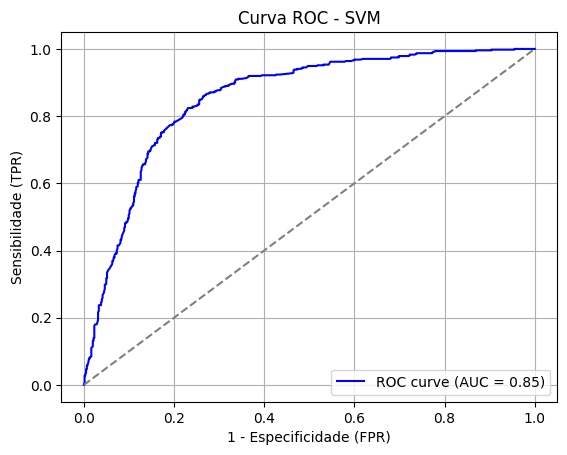

In [67]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {SVM_ROC_AUC_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('1 - Especificidade (FPR)')
plt.ylabel('Sensibilidade (TPR)')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()